In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from typing import Callable
from celluloid import Camera

In [2]:
class LinearFDM:
    def __init__(self, p: Callable, q: Callable, r: Callable, 
                    x0: float, y0: float, xf: float, yf: float, h : float) -> None:

        self.x0, self.xf = x0, xf
        self.y0, self.yf = y0, yf
        N = int((xf - x0)/h)
        self.x = x0 + h*np.arange(N)

        A, B, C, self.D = 1 + h*p(self.x)/2, -2-h**2*q(self.x), 1-h*p(self.x)/2, h**2*r(self.x)
        self.D[1] -= A[1]*y0
        self.D[-1] -= C[-1]*yf

        self.M = np.zeros((N-1, N-1))
        self.M[0, :2] = B[0], C[0]
        for i in range(1, N-2):
            self.M[i, i-1:i+2] = A[i], B[i], C[i]
        self.M[-1, -2:] = A[-1], B[-1]
    
    def inv(self) -> tuple:
        y = np.linalg.inv(self.M).dot(self.D[1:])
        return np.r_[self.x, self.xf], np.r_[self.y0, y, self.yf]

def table(x, y) -> None:
    display(HTML(pd.DataFrame({'x':x, 'y':y}).to_html()))

CPU times: user 2.16 ms, sys: 1.73 ms, total: 3.89 ms
Wall time: 800 µs


,x,y
0,1.0,1.000000
1,1.1,1.093876
2,1.2,1.183023
3,1.3,1.276391
4,1.4,1.373175
5,1.5,1.472787
6,1.6,1.574780
7,1.7,1.678805
8,1.8,1.784585
9,1.9,1.891891


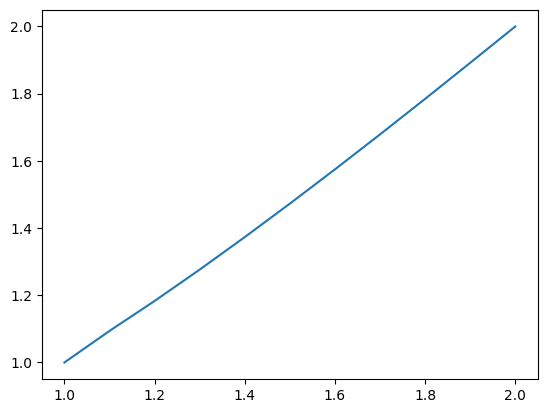

In [3]:
solver = LinearFDM(
    p= lambda x: -2/x, 
    q= lambda x: 2/x**2, 
    r= lambda x: np.sin(np.log(x))/x**2, 
    x0=1, y0=1, xf=2, yf=2, h=0.1
)
%time x, y = solver.inv()
table(x, y)
plt.plot(x, y)
plt.show()

In [4]:
class NonLinearFDM:
    def __init__(self, f: Callable, fy: Callable, fdy: Callable, 
                    x0: float, y0: float, xf: float, yf: float, h : float) -> None:

        self.f, self.fy, self.fdy = f, fy, fdy
        self.x0, self.xf = x0, xf
        self.y0, self.yf = y0, yf
        self.h = h
        self.N = int((xf - x0)/h)
        self.x = x0 + h*np.arange(self.N+1)
        self.y = np.linspace(y0, yf, self.N+1)
    
    def dy(self, i):
        '''
        Forma discreta da primeira derivada

        i: int, índice da malha.    
        '''
        return (self.y[i+1] - self.y[i-1])/(2*self.h)

    def A(self, i):
        '''
        Componente da diagonal inferior do jacobiano: $A_i = \partial _{i-1} g_{i}$

        i: int, índice da malha.    
        '''
        return 1 + (self.h/2)*self.fdy(self.x[i], self.y[i], self.dy(i))

    def B(self, i):
        '''
        Componente da diagonal principal do jacobiano: $B_i = \partial _{i} g_{i}$

        i: int, índice da malha.    
        '''        
        return -2 - (self.h**2)*self.fy(self.x[i], self.y[i], self.dy(i))
    
    def C(self, i):
        '''
        Componente da diagonal superior do jacobiano: $B_i = \partial _{i+1} g_{i}$

        i: int, índice da malha.    
        '''        
        return 1 - (self.h/2)*self.fdy(self.x[i], self.y[i], self.dy(i))
    
    @property
    def J(self):
        '''
        Jacobiano
        '''
        n = self.N-1
        J = np.zeros((n, n))
        J[0, :2] = self.B(1), self.C(1)
        for i in range(1, n-1): # iterando pelas linhas do jacobiano (sem contar as extremidades)
            J[i, i-1:i+2] = self.A(i+1), self.B(i+1), self.C(i+1)
        J[-1, -2:] = self.A(n), self.B(n)
        return J
    
    @property
    def G(self):
        '''
        Sistema discretizado: $G \approx 0$
        '''
        return np.stack([
            self.y[i+1] - 2*self.y[i] + self.y[i-1] - (self.h**2)*self.f(self.x[i], self.y[i], self.dy(i))
            for i in range(1, self.N)
        ])
    
    def step(self):
        self.y[1:self.N] -= np.linalg.inv(self.J).dot(self.G)
        return self.y

In [5]:
solver = NonLinearFDM(
    f= lambda x, y, dy: (1/8)*(32 + 2*x**3 - y*dy), 
    fy= lambda x, y, dy: -dy/8, 
    fdy= lambda x, y, dy: -y/8, 
    x0=1, y0=17, xf=3, yf=43/3, h=0.1
)

fig = plt.figure()
camera = Camera(fig)
for k in range(4):
    plt.plot(solver.x, solver.y, label=f'k={k}')
    camera.snap()
    solver.step()
plt.legend()
table(solver.x, solver.y)
display(HTML(camera.animate().to_html5_video()))
plt.close()

,x,y
0,1.0,17.000000
1,1.1,15.754503
2,1.2,14.771740
3,1.3,13.995677
4,1.4,13.386297
5,1.5,12.914252
6,1.6,12.557538
7,1.7,12.299326
8,1.8,12.126529
9,1.9,12.028814


In [6]:
solver = NonLinearFDM(
    f= lambda x, y, dy: -dy**2 -y + np.log(x), 
    fy= lambda x, y, dy: -1, 
    fdy= lambda x, y, dy: -2*dy, 
    x0=1, y0=0, xf=7, yf=1, h=0.01
)

fig = plt.figure()
camera = Camera(fig)
for k in range(10):
    plt.plot(solver.x, solver.y, label=f'k={k}')
    camera.snap()
    solver.step()
plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
display(HTML(camera.animate().to_html5_video()))
plt.close()

In [7]:
solver = NonLinearFDM(
    f= lambda x, y, dy: 2*y**3, 
    fy= lambda x, y, dy: 6*y**2, 
    fdy= lambda x, y, dy: 0, 
    x0=-1, y0=5, xf=1, yf=2.5, h=0.01
)

fig = plt.figure()
camera = Camera(fig)
for k in range(10):
    plt.plot(solver.x, solver.y, label=f'k={k}')
    camera.snap()
    solver.step()
plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
display(HTML(camera.animate().to_html5_video()))
plt.close()

In [8]:
def f(x, y):
    return np.sqrt(y**3/x)

xf= 20
solver = NonLinearFDM(
    f= lambda x, y, dy: f(x, y), 
    fy= lambda x, y, dy: 0.5*(3*y**2/x)/f(x, y), 
    fdy= lambda x, y, dy: 0, 
    x0=0, y0=1, xf=xf, yf=144/xf**3, h=0.01
)

fig = plt.figure()
camera = Camera(fig)
for k in range(10):
    plt.plot(solver.x, solver.y, label=f'k={k}')
    camera.snap()
    solver.step()
plt.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
display(HTML(camera.animate().to_html5_video()))
plt.close()

